In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

plt.rcParams["figure.figsize"] = (5,5)

In [2]:
img_path = 'testIm.jpeg'

# LP detect

In [3]:
LP_model = cv2.dnn.readNet('weights_and_cfg_files/yolo-tinyv4-obj_last.weights', 'weights_and_cfg_files/yolo-tinyv4-obj.cfg')

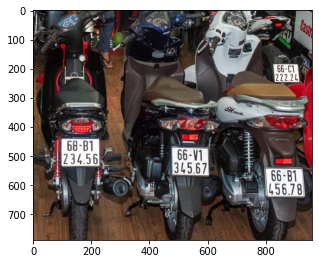

In [4]:
in_img = cv2.imread(img_path)
height, width = in_img.shape[:2]
plt.imshow(cv2.cvtColor(in_img, cv2.COLOR_BGR2RGB))

In [5]:
blob = cv2.dnn.blobFromImage(in_img, 1/255.0, (416,416), 0, swapRB=True, crop=False)
LP_model.setInput(blob)
output_layers_name = LP_model.getUnconnectedOutLayersNames()
layeroutput = LP_model.forward(output_layers_name)

In [6]:
CONFI_THRES = 0.5

confidences = []
boxes = []
class_ids = []
bboxes_yolo = []

for output in layeroutput:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = float(scores[class_id])
        if confidence > CONFI_THRES:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            detected_width = int(detection[2] * width)
            detected_height = int(detection[3] * height)

            x_min = int(center_x - detected_width / 2)
            y_min = int(center_y - detected_height / 2)

            boxes.append([x_min, y_min, detected_width, detected_height])
            bboxes_yolo.append(detection[:4])
            confidences.append(confidence)
            class_ids.append(class_id)

indexes = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=CONFI_THRES, nms_threshold=0.4)

In [7]:
def crop_im(img, bbox):
    ih, iw = img.shape[:2]
    cx, cy, w, h = tuple(bbox * np.array([iw, ih, iw, ih]))
    x1, y1 = int(cx-w/2), int(cy-h/2)
    x2, y2 = x1 + int(w), y1 + int(h)
    x1, y1 = max(0,x1), max(0,y1)
    new_img = img[y1:y2,x1:x2]
    return new_img

In [8]:
license_plates = []

if len(indexes) > 0:
    for i in indexes.flatten():
        crop_resize = cv2.resize(crop_im(in_img, bboxes_yolo[i]), (100, 100))
        blr = cv2.GaussianBlur(crop_resize, (5,5), 1.0)
        license_plates.append(blr)
        print(round(confidences[i], 2))

1.0
0.99
0.99
0.99


# Character detect

In [9]:
char_det_model = cv2.dnn.readNet('weights_and_cfg_files/yolov4-tiny-char-detect_last.weights', 'weights_and_cfg_files/yolov4-tiny-char-detect.cfg')

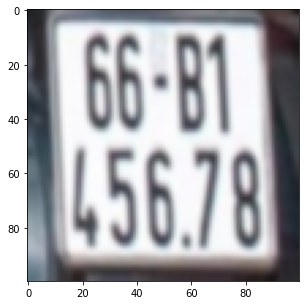

In [10]:
lp_img = license_plates[0]
height, width = lp_img.shape[:2]
plt.imshow(cv2.cvtColor(lp_img, cv2.COLOR_BGR2RGB))

In [11]:
blob = cv2.dnn.blobFromImage(lp_img, 1/255.0, (416,416), 0, swapRB=True, crop=False)
char_det_model.setInput(blob)
output_layers_name = char_det_model.getUnconnectedOutLayersNames()
layeroutput = char_det_model.forward(output_layers_name)

In [12]:
CHAR_THRES = 0.7

confidences = []
boxes = []
bboxes_yolo = []

for output in layeroutput:
    for detection in output:
        confidence = float(detection[5])
        if confidence > CHAR_THRES:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            detected_width = int(detection[2] * width)
            detected_height = int(detection[3] * height)

            x_min = int(center_x - detected_width / 2)
            y_min = int(center_y - detected_height / 2)

            boxes.append([x_min, y_min, detected_width, detected_height])
            bboxes_yolo.append(detection[:4])
            confidences.append(confidence)

indexes = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=CHAR_THRES, nms_threshold=0.4)

In [13]:
characters = []
char_centers = []

if len(indexes) > 0:
    for i in indexes.flatten():
        bbox = bboxes_yolo[i].copy()
        bbox[2] += 0.05
        bbox[3] += 0.05
        new_im = crop_im(lp_img, bbox)
        new_im = cv2.cvtColor(new_im, cv2.COLOR_BGR2GRAY)
        new_im = cv2.resize(new_im, (int(28*new_im.shape[1]/new_im.shape[0]*1.7), 28))
        border = 28-new_im.shape[1]
        if border % 2 == 0:
            border_L = border_R = border // 2
        else:
            border_L = border // 2
            border_R = border_L + 1
        new_im = cv2.copyMakeBorder(new_im, 0, 0, border_L, border_R, cv2.BORDER_REPLICATE)
        characters.append(new_im)
        print(round(confidences[i], 2))
    char_centers = [bboxes_yolo[i][:2] for i in indexes.flatten()]

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


# Character recognize

In [14]:
ALPHA_DICT = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'K', 19: 'L',
    20: 'M', 21: 'N', 22: 'P', 23: 'R', 24: 'S', 25: 'T', 26: 'U', 27: 'V', 28: 'X', 29: 'Y', 30: 'Z'}

In [15]:
reco_model = Sequential()
reco_model.add(Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(28, 28, 1)))
reco_model.add(BatchNormalization())
reco_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(MaxPooling2D(pool_size=(2, 2)))

reco_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(MaxPooling2D(pool_size=(2, 2)))

reco_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(MaxPooling2D(pool_size=(2, 2)))

reco_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(MaxPooling2D(pool_size=(2, 2)))

reco_model.add(Flatten())
reco_model.add(Dense(1024, activation='relu'))
reco_model.add(Dropout(0.5))
reco_model.add(Dense(31, activation='softmax'))

2021-09-24 21:55:39.548928: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-24 21:55:39.549633: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
reco_model.load_weights('weights_and_cfg_files/myCNN_backup_28_BN.h5')

In [17]:
char_tensor = np.array(characters).reshape((len(characters), 28, 28, 1))
char_tensor = char_tensor / 255.0

In [18]:
result = reco_model.predict(char_tensor)
result = np.argmax(result, axis=1)

2021-09-24 21:55:39.991354: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


In [19]:
chars = [ALPHA_DICT[i] for i in result]

In [20]:
def format_LP(chars, char_centers):
    x = [c[0] for c in char_centers]
    y = [c[1] for c in char_centers]
    y_mean = np.mean(y)

    if y_mean - min(y) < 0.1:
        return [i for _, i in sorted(zip(x, chars))]
    
    sorted_chars = [i for _, i in sorted(zip(x, chars))]
    y = [i for _, i in sorted(zip(x, y))]
    first_line = [i for i in range(len(chars)) if y[i] < y_mean]
    second_line = [i for i in range(len(chars)) if y[i] > y_mean]
    return [sorted_chars[i] for i in first_line] + ['-'] + [sorted_chars[i] for i in second_line]

In [21]:
final_lab = ''.join(format_LP(chars, char_centers))

# Result

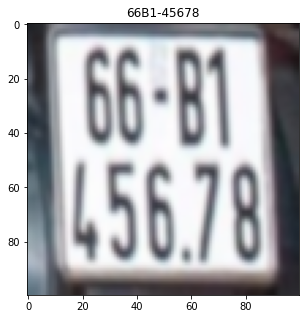

In [22]:
plt.imshow(cv2.cvtColor(license_plates[0], cv2.COLOR_BGR2RGB))
plt.title(final_lab)
plt.show()